In [1]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

In [2]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''
    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data

data = readArxivFile('arxiv-metadata-oai-snapshot.json', 
                     ['id', 'authors','authors_parsed','update_date','categories'])

In [3]:
data["year"] = pd.to_datetime(data["update_date"]).dt.year #将update_date从例如2019-02-20的str变为datetime格式，并提取处year
del data["update_date"] #删除 update_date特征，
data = data[data["year"] >= 2019] #找出 year 中2019年以后的数据，并将其他数据删除

In [4]:

data.head()

,authors,authors_parsed,categories,id,year
296,"Sung-Chul Yoon, Philipp Podsiadlowski and Step...","[[Yoon, Sung-Chul, ], [Podsiadlowski, Philipp,...",astro-ph,0704.0297,2019
341,B. Dugmore and PP. Ntumba,"[[Dugmore, B., ], [Ntumba, PP., ]]",math.AT,0704.0342,2019
359,T.V. Zaqarashvili and K Murawski,"[[Zaqarashvili, T. V., ], [Murawski, K, ]]",astro-ph,0704.0360,2019
524,"Sezgin Aygun, Ismail Tarhan, Husnu Baysal","[[Aygun, Sezgin, ], [Tarhan, Ismail, ], [Baysa...",gr-qc,0704.0525,2019
534,"Antonio Pipino (1,3), Thomas H. Puzia (2,4), a...","[[Pipino, Antonio, ], [Puzia, Thomas H., ], [M...",astro-ph,0704.0535,2019


In [5]:

data = data[data['categories'].apply(lambda x : 'cs.CV' in x)] # 选择类别为cs.CV下面的论文

In [6]:

data.head()

,authors,authors_parsed,categories,id,year
48709,Mahesh Pal,"[[Pal, Mahesh, ]]",cs.NE cs.CV,0802.1412,2019
122831,"Serguei A. Mokhov, Stephen Sinclair, Ian Cl\'e...","[[Mokhov, Serguei A., , for the MARF R&D Group...",cs.SD cs.CL cs.CV cs.MM cs.NE,0905.1235,2019
274867,"Chris Aholt, Bernd Sturmfels, Rekha Thomas","[[Aholt, Chris, ], [Sturmfels, Bernd, ], [Thom...",math.AG cs.CV,1107.2875,2019
288218,Dae-Woong Lee,"[[Lee, Dae-Woong, ]]",cs.CV,1109.3850,2020
292514,"Aman Chadha, Divya Jyoti, M. Mani Roja","[[Chadha, Aman, ], [Jyoti, Divya, ], [Roja, M....",cs.CV cs.CR cs.IT cs.MM eess.IV math.IT,1110.1208,2020


In [7]:
import networkx as nx 
# 创建无向图
plt.figure(figsize=(10, 6))
G = nx.Graph()
# 只用五篇论文进行构建
for row in data.iloc[:5].itertuples():
  authors = row[3]
  authors = [' '.join(x[:-1]) for x in authors]
  # 第一个作者 与 其他作者链接
  for author in authors[1:]:
    G.add_edge(authors[0],author) #　添加节点２，３并链接２３节点

<Figure size 720x432 with 0 Axes>

C:\Users\60381\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


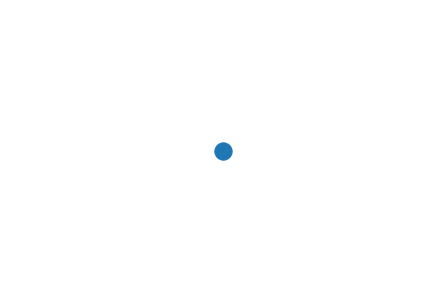

In [8]:

# 将作者关系图进行绘制：
nx.draw(G, with_labels=True)

In [9]:
try:
    print(nx.dijkstra_path(G, 'Chadha Aman', 'Jyoti Divya'))  # 求最短路径
except:
    print('No path')

No path


In [10]:
try:
    print(nx.dijkstra_path(G, 'Roja M. Mani', 'Jyoti Divya'))  # 求最短路径
except:
    print('No path')

No path


In [11]:
G1 = nx.Graph()

for row in data.iloc[:1000].itertuples():
    authors = row[3]
    authors = [' '.join(x[:-1]) for x in authors]
    
    # 第一个作者 与 其他作者链接
    for author in authors[1:]:
        G1.add_edge(authors[0],author) #　添加节点２，３并链接２３节点

In [12]:
num_sorted = sorted(dict(G1.degree()).items(),key=lambda x :x[1],reverse=True)
for i,(name,num) in enumerate(num_sorted):
    if i <3:
        print(name,':',num)

 : 2


In [13]:
def func(x):
    strs = ''
    for i in x:
        name = ' '.join(i)
        strs += name+','
    return strs

In [14]:
data_liu = data['authors_parsed'].iloc[:1000].apply(func = func)

In [15]:

data_liu = data_liu[data_liu.str.contains('Liu Yun')]

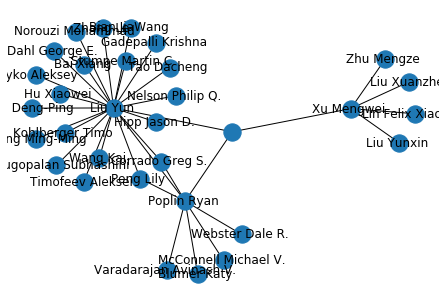

In [16]:
# 创建无向图
import networkx as nx
G2 = nx.Graph()

# 只用五篇论文进行构建
for row in data_liu.to_frame().itertuples():
    authors = row[1]
    authors = authors.split(',')
    
    # 第一个作者 与 其他作者链接
    for author in authors[1:]:
        G2.add_edge(authors[0],author) #　添加节点２，３并链接２３节点
nx.draw(G2,with_labels=True)

C:\Users\60381\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """


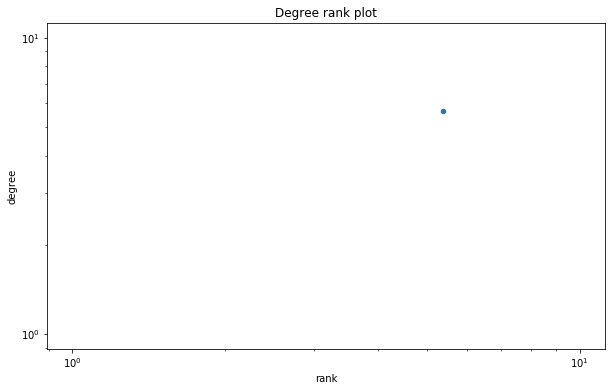

In [17]:

degree_sequence = sorted([d for n, d in G1.degree()], reverse=True)  # 节点度是与节点相邻的边数。
dmax = max(degree_sequence)

plt.figure(figsize=(10, 6))
plt.loglog(degree_sequence, "r-", marker="o") # 对数图
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45, 0.45, 0.45, 0.45])
Gcc = G1.subgraph(sorted(nx.connected_components(G1), key=len, reverse=True)[0]) ## G中相连组件最多的图

pos = nx.spring_layout(Gcc)
plt.axis("off")
nx.draw_networkx_nodes(Gcc, pos, node_size=20)
nx.draw_networkx_edges(Gcc, pos, alpha=0.4)
plt.show()

IndexError: list index out of range

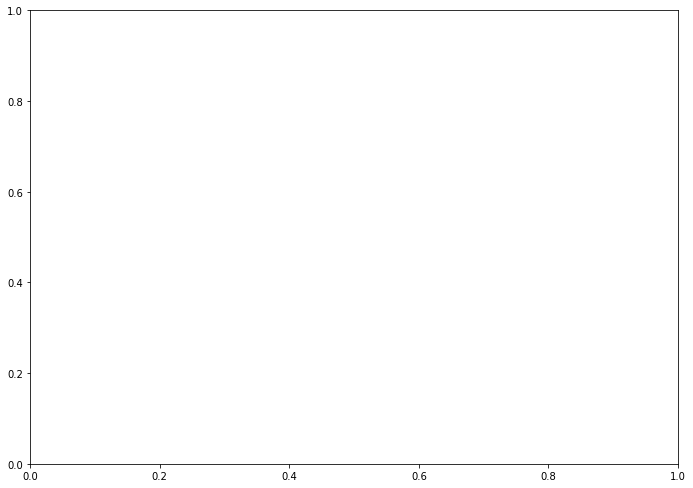

In [18]:
plt.figure(figsize=(20, 14))
plt.axes([0.45, 0.45, 0.45, 0.45])
Gcc = G1.subgraph(sorted(nx.connected_components(G1), key=len, reverse=True)[1]) 

pos = nx.spring_layout(Gcc)
plt.axis("off")
nx.draw_networkx_nodes(Gcc, pos, node_size=20)
nx.draw_networkx_edges(Gcc, pos, alpha=0.4)
plt.show()